In [168]:
%matplotlib inline

import pandas
import numpy
import sklearn
from sklearn import metrics, datasets, model_selection

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


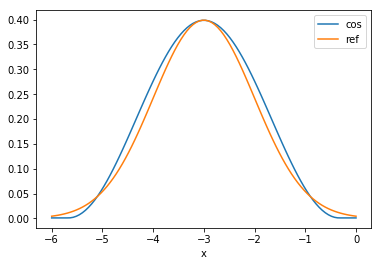

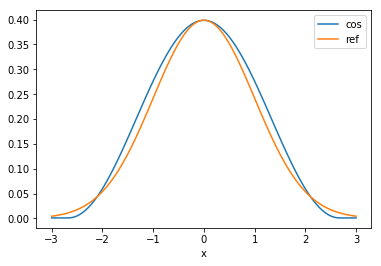

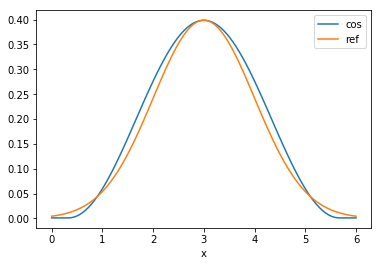

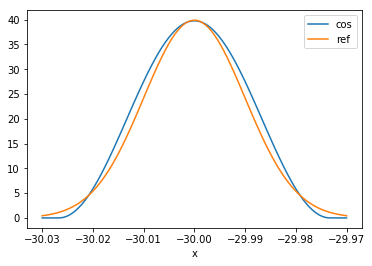

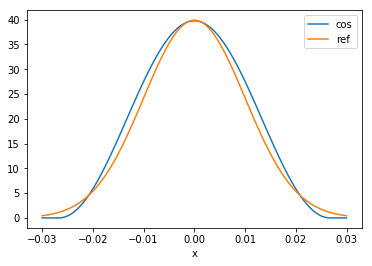

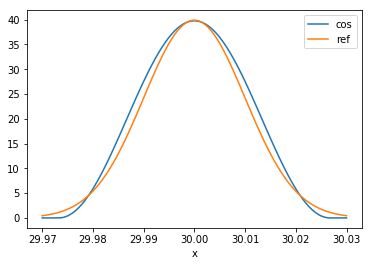

In [169]:
np = numpy

def prob_ref(x, mean, std):
    exponent = np.exp(- ((x - mean)**2 / (2 * std**2)))
    return (exponent / (np.sqrt(2 * np.pi) * std))

# https://www.johndcook.com/blog/2010/04/29/simple-approximation-to-normal-distribution/
def prob_cos(x, mean, std):
    bs1 = 7.9 # fudge factor
    bs2 = 0.85 # fudge factor
    xm = (x - mean) / (std * bs2)
    xm = numpy.clip(xm, -numpy.pi, numpy.pi)
    s = (1 + numpy.cos(xm)) / 2*np.pi
    return 0.001 + s * 1/(std*bs1)

# FIXME: does not work at all??
def prob_logistic(x, mean, std):
    X = x + 2
    s = 1/(1 + numpy.exp((-0.07056*X**3) - (1.5976*X)))
    return s / 2.73

def compare_p(mean=0.0, std=1.0, sigma=3.0):
    samples = numpy.linspace(mean-(sigma*std), mean+(sigma*std), 100)
    ref = prob_ref(samples, mean, std)
    cos = prob_cos(samples, mean, std)
    logistic = prob_logistic(samples, mean, std)
    df = pandas.DataFrame({
        'x': samples,
        'ref': ref,
        'cos': cos,
        #'logistic': logistic,
    })
    df.plot(x='x')

for mean, std in zip([-3.0, 0.0, 3.0, -30.0, 0.0, 30.0], [1.0, 1.0, 1.0, 0.01, 0.01, 0.01]):
    compare_p(mean, std)

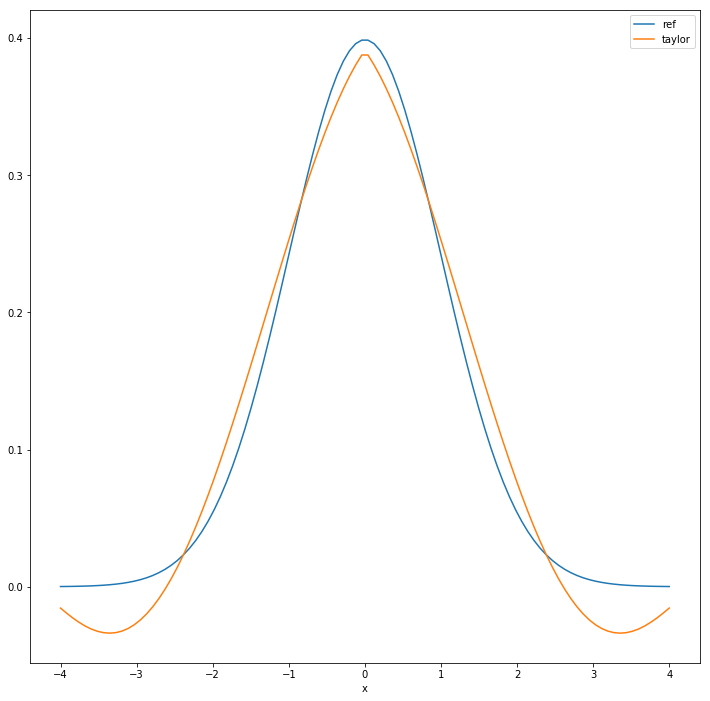

In [170]:
from scipy.interpolate import approximate_taylor_polynomial

def f(x):
    return prob_ref(x, mean=0.0, std=1.0)
prob_half = approximate_taylor_polynomial(f, 0.2, degree=5, scale=5.0)

def half_single(xm):
    if xm >= 0: 
        return prob_half(xm)
    else:
        return prob_half(-xm)
    
def prob_taylor(x, mean, std):
    xm = (x - mean) / std
    out = [half_single(v) for v in xm]
    return numpy.array(out)


points = numpy.linspace(-4, 4, 100)
df = pandas.DataFrame({
    'x': points,
    'ref': prob_ref(points, 0.0, 1.0),
    #'half': prob_half(points),
    'taylor': prob_taylor(points, 0.0, 1.0),
}).plot(x='x', figsize=(12,12))

In [175]:
x=1
x0=2.08
np.abs(x-x0)

1.08

[ 0.34247959  2.00265729  0.0951662  -0.07833795 -0.03716455  0.23640959]


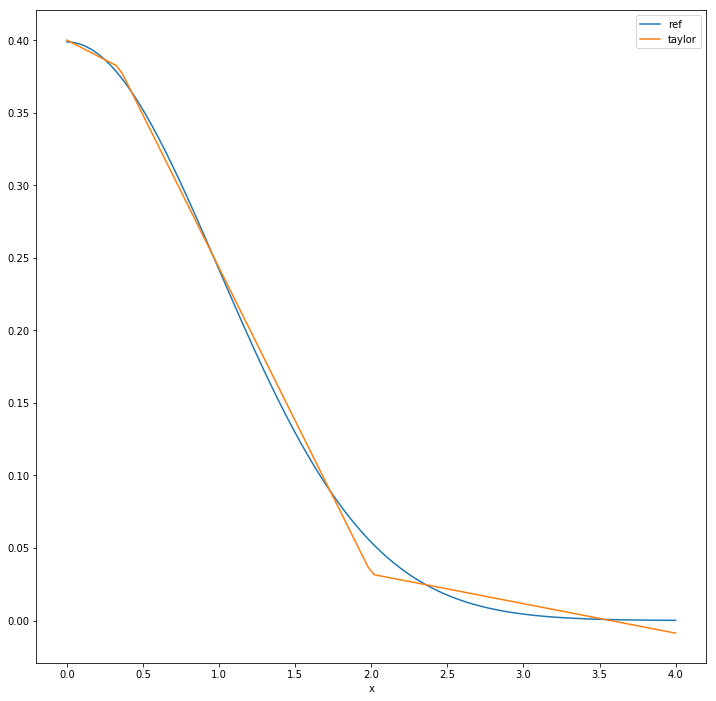

In [181]:
def piecewise_linear(x, x0, a, b, c):
    y = a*np.abs(x-x0) + b*x + c
    return y

def piecewise_linear2(x, x0, x1, aa, a, b, c):
    y = aa*np.abs(x-x1) + a*np.abs(x-x0) + b*x + c
    return y

def piecewise_linear3(x, x0, x1, x2, aaa, aa, a, b, c):
    y = aaa*np.abs(x-x2) + aa*np.abs(x-x1) + a*np.abs(x-x0) + b*x + c
    return y

from scipy.optimize import curve_fit
fitx = numpy.linspace(0, 4, 30)
fity = prob_ref(fitx, 0.0, 1.0)
p0 = [0.0, 1.0, 3.14]
popt_piecewise, pcov = curve_fit(piecewise_linear2, fitx, fity)
print(popt_piecewise)

points = numpy.linspace(0, 4, 100)
df = pandas.DataFrame({
    'x': points,
    'ref': prob_ref(points, 0.0, 1.0),
    #'half': prob_half(points),
    'taylor': piecewise_linear2(points, *popt_piecewise)
}).plot(x='x', figsize=(12,12))

samples = numpy.linspace(0, 7, 1000)

In [120]:
%timeit prob_ref(samples, 0.0, 1.0) 

171 µs ± 2.82 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [121]:
%timeit prob_cos(samples, 0.0, 1.0)

248 µs ± 5.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [140]:
%timeit prob_taylor(samples)

142 µs ± 2.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
samples = numpy.linspace(0, mean+(sigma*std), 100)
ref = prob_ref(samples, mean, std)

In [141]:
class GaussianNB(object):
    def __init__(self):
        pass

    def fit(self, X, y):
        separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        self.model = np.array([np.c_[np.mean(i, axis=0), np.std(i, axis=0)]
                    for i in separated])
        return self

    def _prob(self, x, mean, std):
        return np.log(prob_ref(x, mean, std))

    def predict_log_proba(self, X):
        return [[sum(self._prob(i, *s) for s, i in zip(summaries, x))
                for summaries in self.model] for x in X]

    def predict(self, X):
        return np.argmax(self.predict_log_proba(X), axis=1)

    def score(self, X, y):
        return sum(self.predict(X) == y) / len(y)
    
class GaussianCos(GaussianNB):
    def _prob(self, x, mean, std):
        return np.log(prob_cos(x, mean, std))
    
class GaussianTaylor(GaussianNB):
    def _prob(self, x, mean, std):
        return np.log(prob_taylor(x, mean, std))
    


In [142]:
# Data
data = datasets.load_breast_cancer()
label_names = data['target_names']
labels = data['target']
feature_names = data['feature_names']
features = data['data']

train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.33,
                                                          random_state=42)
classifiers = [
    GaussianNB(),
    GaussianCos(),
    GaussianTaylor(),
]
acc = []
for estimator in classifiers:
    # Train
    gnb = estimator
    model = gnb.fit(train, train_labels)
    # Tests
    preds = gnb.predict(test)
    acc.append(metrics.accuracy_score(test_labels, preds))

print(acc)

TypeError: __call__() takes 2 positional arguments but 4 were given